In [457]:
import pandas as pd
from datetime import datetime
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tarfile
import os

In [458]:
time_interval = '1T' # we group trades on time_interval minutes intervals
N = 10 # number of days
T = 100 # number of stocks

In [459]:
import tarfile
import pandas as pd

# Define the path to the tar file
tar_file_path = 'data/period_data.tar'

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Open the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Iterate through each member in the tar file
    for member in tar.getmembers():
        # Check if the file is a .parquet file
        if member.isfile() and member.name.endswith('.parquet'):
            # Extract the file
            extracted_file = tar.extractfile(member)
            if extracted_file:
                # Load the parquet file into a DataFrame
                daily_df = pd.read_parquet(extracted_file)
                # Reset the index and keep it as a column
                daily_df.reset_index(inplace=True)
                # Append to the combined DataFrame
                combined_df = pd.concat([combined_df, daily_df], ignore_index=True)

# Print the combined DataFrame's shape and a preview
print(combined_df.shape)
combined_df[(combined_df['stock'] == 'XLY')]

(4033946, 7)


,xltime,bid_price,bid_volume,ask_price,ask_volume,price,stock
18804,2012-03-01 09:30:00-05:00,43.361260,1241,43.380709,1210,43.370861,XLY
18805,2012-03-01 09:31:00-05:00,43.403669,5281,43.415263,8197,43.410720,XLY
18806,2012-03-01 09:32:00-05:00,43.440012,10012,43.451292,9279,43.445438,XLY
18807,2012-03-01 09:33:00-05:00,43.440861,9545,43.451691,8760,43.446044,XLY
18808,2012-03-01 09:34:00-05:00,43.413030,15486,43.424296,8367,43.416982,XLY
...,...,...,...,...,...,...,...
4033941,2012-12-31 15:55:00-05:00,47.417671,55952,47.428298,120881,47.424936,XLY
4033942,2012-12-31 15:56:00-05:00,47.386378,161080,47.396953,227951,47.392575,XLY
4033943,2012-12-31 15:57:00-05:00,47.352095,55767,47.363543,131497,47.360134,XLY
4033944,2012-12-31 15:58:00-05:00,47.370508,67879,47.381836,147840,47.378272,XLY


Load the train and val files, merge them, keep only data before 4pm and add a log return column

In [460]:
filtered_df = combined_df[combined_df['xltime'].dt.time < datetime.strptime('16:00', '%H:%M').time()]
filtered_df["Date"] = filtered_df["xltime"].dt.date

filtered_df['log-return'] = np.log(filtered_df['price']).diff()
filtered_df['log-return'] = filtered_df['log-return']#.apply(lambda x: 0 if abs(x) > 10 else x)
filtered_df = filtered_df.dropna(subset=['log-return'])
filtered_df

C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\1005052118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = filtered_df["xltime"].dt.date
C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\1005052118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log-return'] = np.log(filtered_df['price']).diff()
C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\1005052118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

MemoryError: Unable to allocate 15.4 MiB for an array with shape (4033839, 1) and data type int32

Create the dataframe: basically a table with each columns as days, each row as a stock logreturn on a designated interval

In [ ]:
filtered_df['Floored_Timestamp'] = filtered_df['xltime'].dt.floor(time_interval) # Floor the timestamp to the nearest time_interval minutes
# add a column with stock and new timestamp for merging
filtered_df['Stock_Timestamp'] = filtered_df['stock'] + "_" + filtered_df['Floored_Timestamp'].dt.strftime('%H:%M:%S.%f')

grouped_df = filtered_df.pivot_table(index='Stock_Timestamp', columns='Date', values='log-return', aggfunc='mean')
grouped_df = grouped_df.fillna(0)
grouped_df = grouped_df.iloc[:, :50]
print(grouped_df.shape)
grouped_df.head()


(21450, 210)


Date,2012-03-01,2012-03-02,2012-03-05,2012-03-06,2012-03-07,2012-03-08,2012-03-09,2012-03-12,2012-03-13,2012-03-14,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Stock_Timestamp,,,,,,,,,,,,,,,,,,,,,
CORN_09:30:00.000000,0.000000,-0.062594,-0.052893,-0.064044,-0.046276,-0.069677,-0.093428,-0.084885,-0.059401,-8.052193e-02,...,-0.006780,-0.041559,-0.048061,-0.077001,-0.071567,-0.052556,-0.869514,-0.060003,-0.063433,-0.055929
CORN_09:31:00.000000,-0.000254,0.000541,-0.001146,-0.001364,-0.000149,0.001893,0.000000,0.000000,0.000426,-1.398239e-03,...,-0.000422,-0.000110,-0.000342,-0.000381,-0.000135,0.000000,-0.000555,-0.000236,0.000310,-0.000052
CORN_09:32:00.000000,0.000699,-0.000827,-0.000711,-0.000645,-0.000800,0.001051,0.000000,0.000000,-0.000847,-3.530533e-04,...,0.000573,-0.000049,-0.000011,-0.000366,-0.000095,0.000520,0.000154,0.000545,0.000143,0.000090
CORN_09:33:00.000000,-0.000368,-0.000562,0.000795,0.000000,-0.001172,0.000012,0.000000,0.000000,-0.004030,1.016018e-05,...,0.000168,-0.000018,0.000525,-0.000969,-0.000025,0.000499,0.000013,0.000019,0.000325,0.000000
CORN_09:34:00.000000,0.000000,-0.000283,0.000248,0.001353,-0.003195,0.000034,-0.000529,-0.003202,-0.001454,5.166163e-07,...,-0.000367,-0.000080,0.000179,0.000713,0.000491,0.000144,0.000114,-0.000050,0.000155,0.000016


In [ ]:
#create correlation dataframe between days
corr = grouped_df.corr()
corr.head()

Date,2012-03-01,2012-03-02,2012-03-05,2012-03-06,2012-03-07,2012-03-08,2012-03-09,2012-03-12,2012-03-13,2012-03-14,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,1.000000,0.997173,0.996447,0.996482,0.986457,0.996605,0.997141,0.996832,0.996574,0.997034,...,0.985784,0.986058,0.986460,0.986504,0.986402,0.894847,0.979324,0.982738,0.978717,0.986464
2012-03-02,0.997173,1.000000,0.997992,0.998191,0.987608,0.997538,0.998171,0.998494,0.997207,0.998273,...,0.986302,0.986605,0.987133,0.987139,0.986999,0.896174,0.981039,0.983179,0.979237,0.986737
2012-03-05,0.996447,0.997992,1.000000,0.997987,0.988017,0.998530,0.998450,0.998790,0.997656,0.998432,...,0.985520,0.985736,0.986198,0.986098,0.986080,0.894786,0.979874,0.982172,0.977852,0.985708
2012-03-06,0.996482,0.998191,0.997987,1.000000,0.987945,0.997884,0.998350,0.998106,0.997251,0.997886,...,0.984586,0.984811,0.985322,0.985263,0.985238,0.895132,0.979198,0.981388,0.977113,0.984666
2012-03-07,0.986457,0.987608,0.988017,0.987945,1.000000,0.987635,0.987895,0.987762,0.987215,0.987569,...,0.980486,0.980345,0.980864,0.980166,0.980452,0.889644,0.973343,0.975923,0.971295,0.979214


Louvain Clustering

In [452]:
# process data for louvain clustering
def get_sortest_eig(C):
    '''
    input 
        C: correlation matrix
        
    output: 
        l: eigenvalues
        v: eigenvectors 
    '''
    
    l,v = np.linalg.eigh(C)
    ordn = np.argsort(l)
    l,v = l[ordn],v[:,ordn]
    return l,v

l, v = get_sortest_eig(corr)

lambda_limit = 1e-1
len(l[l<lambda_limit]) 
selected_indices = [i for i, l in enumerate(l) if l <= lambda_limit]

C_r = np.zeros_like(corr)

for i in selected_indices:
    v_i = v[:, i]  # Get the i-th eigenvector
    outer_product = np.outer(v_i, v_i)  # Compute outer product
    C_r += l[i] * outer_product  # Add scaled matrix to the sum

C_m = l[-1] * np.outer(v[-1, :],v[-1, :])
C_0 = C_r + C_m
C = abs(corr - C_0)
G = nx.from_pandas_adjacency(C)


In [453]:
# partition using louvain clustering
partition = community_louvain.best_partition(G)
print(len(partition))
print(partition)

210
{datetime.date(2012, 3, 1): 1, datetime.date(2012, 3, 2): 1, datetime.date(2012, 3, 5): 1, datetime.date(2012, 3, 6): 0, datetime.date(2012, 3, 7): 1, datetime.date(2012, 3, 8): 1, datetime.date(2012, 3, 9): 1, datetime.date(2012, 3, 12): 0, datetime.date(2012, 3, 13): 1, datetime.date(2012, 3, 14): 1, datetime.date(2012, 3, 15): 1, datetime.date(2012, 3, 16): 1, datetime.date(2012, 3, 19): 1, datetime.date(2012, 3, 20): 0, datetime.date(2012, 3, 21): 1, datetime.date(2012, 3, 22): 1, datetime.date(2012, 3, 23): 1, datetime.date(2012, 3, 26): 1, datetime.date(2012, 3, 27): 0, datetime.date(2012, 3, 28): 1, datetime.date(2012, 3, 29): 1, datetime.date(2012, 3, 30): 1, datetime.date(2012, 4, 2): 1, datetime.date(2012, 4, 3): 0, datetime.date(2012, 4, 4): 0, datetime.date(2012, 4, 5): 0, datetime.date(2012, 4, 9): 0, datetime.date(2012, 4, 10): 0, datetime.date(2012, 4, 11): 0, datetime.date(2012, 4, 12): 0, datetime.date(2012, 4, 13): 1, datetime.date(2012, 4, 16): 0, datetime.date(2

Quick cell to display total logreturns of each cluster

In [454]:
# Convert partition to a dataframe
partition_df = pd.DataFrame(list(partition.items()), columns=['Date', 'Cluster'])

# Merge log return data with cluster assignments
log_return_clustered = filtered_df.merge(partition_df, on='Date')
log_return_clustered.groupby('Cluster')["log-return"].sum()


Cluster
0   -0.281817
1   -0.044320
Name: log-return, dtype: float64

Number of clusters

In [455]:
# how many clusters
num_clusters = len(set(partition.values()))
num_clusters

2

Clustering visualization

C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\1841700985.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


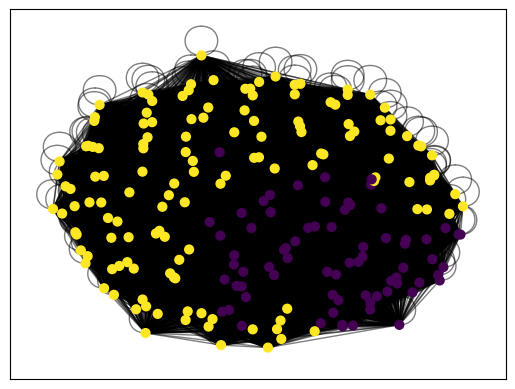

In [456]:
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()